In [1]:
import pandas as pd
import torch
from pytorch_lightning import LightningModule, LightningDataModule
from torch.nn import Sequential, LazyLinear, ReLU, MSELoss
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader
from torchdata.datapipes.map import SequenceWrapper, Zipper


class MyNet(LightningModule):
    def __init__(self, nhidden=64, lr=1e-3):
        super().__init__()
        
        self.net = Sequential(
            LazyLinear(nhidden), ReLU(),
            LazyLinear(1)
        )
        self.loss = MSELoss()
        
        self.lr = lr

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)
        
    def forward(self, x):
        return self.net(x)
        
    def _training_step(self, batch, loss_name):
        inputs, targets = batch
        outputs = self.forward(inputs)
        loss = self.loss(outputs, targets)
        self.log(loss_name, loss)
        return loss

    def training_step(self, batch, *args, **kwargs):
        return self._training_step(batch, 'train')
    def validation_step(self, batch, *args, **kwargs):
        return self._training_step(batch, 'val')
    
    
class MyData(LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.df = pd.read_csv('pantheon+SH0ES.dat', delimiter=' ')
        self.dataset = Zipper(*(
            SequenceWrapper(torch.tensor(self.df[keys].to_numpy(), dtype=torch.get_default_dtype()))
            for keys in (
                ['zCMB', 'x1', 'c', 'HOST_LOGMASS', 'HOST_ANGSEP', 'VPEC'],
                ['mB']
            )
        ))
    
    def prepare_data(self):
        self.train_dataset, self.val_dataset = random_split(
            self.dataset, [0.91, 0.09],
            generator=torch.Generator().manual_seed(42)
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, shuffle=True, batch_size=self.batch_size)

In [ ]:
from pytorch_lightning import Trainer

net = MyNet()
data = MyData(10)

trainer = Trainer(
    max_steps=10_000,
    enable_model_summary=False,
)
trainer.fit(net, datamodule=data)

In [4]:
net.eval();

In [10]:
zs, preds, ys = [], [], []
for (x, y) in data.dataset:
    zs.append(x[0].item())
    preds.append(net(x).item())
    ys.append(y.item())

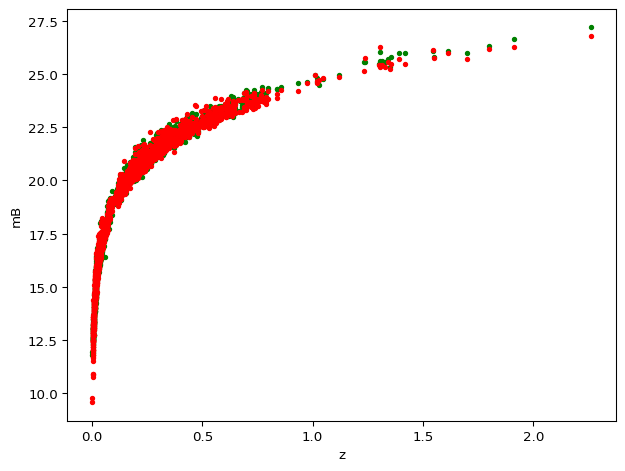

In [11]:
from matplotlib import pyplot as plt

plt.plot(zs, preds, 'g.')
plt.plot(zs, ys, 'r.')
plt.gca().set(xlabel='z', ylabel='mB');
# plt.gca().set(
#     xlabel='true', ylabel='predicted'
# );